<a href="https://colab.research.google.com/github/sun-rabbit/Colab2GithubDemo/blob/main/torchaudio_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [ ]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]
                # Python中的方法用于规范化指定的路径。在路径规范化过程中，所有冗余分隔符和up-level引用均折叠
        if subset == "validation":  #验证集
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]   #utterance_number。发声次数

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


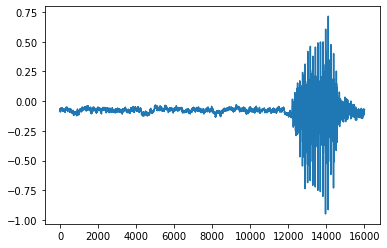

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [ ]:
waveform_last, *_ = train_set[-1]
print(*_)
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

16000 zero fffcabd1 0


## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):  #定义前向传播过程
        x = self.conv1(x) #将x输入卷积中
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        # print(x.shape,'-----')
        x = F.avg_pool1d(x, int(x.shape[-1]))
        # x = F.avg_pool1d(x, 1)
        # x = F.avg_pool1d(x,8000)
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)



def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
print(transformed)

tensor([[-0.0501, -0.0796, -0.0794,  ..., -0.0717, -0.0701, -0.0755]])


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=0)

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)
        #查看数据维度
        # print(data.size(),'----')
        #在转换onnx里面会用到这个纬度

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            #训练时保存模型
            torch.save(model,"M5.pth")
        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
log_interval = 20
n_epoch = 30

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.#转换需要与模型和数据位于同一设备上。
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.0026666666666666666/30 [00:00<1:31:13, 182.45s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.664053


  0%|          | 0.05599999999999999/30 [00:06<58:51, 117.92s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.539932


  0%|          | 0.10933333333333328/30 [00:12<57:19, 115.07s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.732061


  1%|          | 0.16266666666666676/30 [00:18<53:58, 108.53s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.822746


  1%|          | 0.21600000000000033/30 [00:24<52:50, 106.46s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.739248


  1%|          | 0.2693333333333337/30 [00:29<49:52, 100.65s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.633910


  1%|          | 0.3226666666666667/30 [00:35<49:10, 99.43s/it]  

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.678649


  1%|▏         | 0.3759999999999997/30 [00:40<49:16, 99.79s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.660819


  1%|▏         | 0.42933333333333273/30 [00:45<48:28, 98.36s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.636701


  2%|▏         | 0.48266666666666574/30 [00:50<46:06, 93.73s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.792110


  2%|▏         | 0.5359999999999995/30 [00:55<51:50, 105.57s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.874255


  2%|▏         | 0.5893333333333336/30 [01:00<43:59, 89.74s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.562933


  2%|▏         | 0.6426666666666677/30 [01:05<42:12, 86.25s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.759941


  2%|▏         | 0.6960000000000018/30 [01:09<42:18, 86.62s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.548321


  2%|▏         | 0.749333333333336/30 [01:14<40:47, 83.67s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.814062


  3%|▎         | 0.8026666666666701/30 [01:19<43:03, 88.48s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.667586


  3%|▎         | 0.8560000000000042/30 [01:23<41:48, 86.07s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.727294


  3%|▎         | 1.0000000000000062/30 [01:32<27:08, 56.16s/it]


Test Epoch: 1	Accuracy: 8219/11005 (75%)



  3%|▎         | 1.0026666666666728/30 [01:32<30:50, 63.83s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.704476


  4%|▎         | 1.0560000000000047/30 [01:36<37:22, 77.46s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.710989


  4%|▎         | 1.1093333333333366/30 [01:41<38:22, 79.70s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.726610


  4%|▍         | 1.1626666666666685/30 [01:45<37:42, 78.45s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.559449


  4%|▍         | 1.2160000000000004/30 [01:49<36:45, 76.63s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.547723


  4%|▍         | 1.2693333333333323/30 [01:53<38:03, 79.49s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.664002


  4%|▍         | 1.3226666666666642/30 [01:58<38:16, 80.09s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.783025


  5%|▍         | 1.3759999999999961/30 [02:02<36:55, 77.39s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.743678


  5%|▍         | 1.429333333333328/30 [02:06<37:34, 78.90s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.754795


  5%|▍         | 1.48266666666666/30 [02:10<37:33, 79.01s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.556253


  5%|▌         | 1.5359999999999918/30 [02:15<37:44, 79.56s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.662288


  5%|▌         | 1.5893333333333237/30 [02:19<36:49, 77.76s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.587285


  5%|▌         | 1.6426666666666556/30 [02:23<38:21, 81.17s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.645373


  6%|▌         | 1.6959999999999875/30 [02:27<37:11, 78.85s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.836801


  6%|▌         | 1.7493333333333194/30 [02:31<36:37, 77.80s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.601441


  6%|▌         | 1.8026666666666513/30 [02:35<36:36, 77.91s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.665636


  6%|▌         | 1.8559999999999832/30 [02:40<36:27, 77.72s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.648086


  7%|▋         | 1.9999999999999793/30 [02:47<22:58, 49.22s/it]


Test Epoch: 2	Accuracy: 7764/11005 (71%)



  7%|▋         | 2.0053333333333128/30 [02:48<29:29, 63.21s/it]

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.505904


  7%|▋         | 2.0559999999999823/30 [02:52<44:29, 95.52s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.520983


  7%|▋         | 2.1093333333333186/30 [02:57<36:43, 79.00s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.560459


  7%|▋         | 2.162666666666655/30 [03:01<36:28, 78.61s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.529763


  7%|▋         | 2.2159999999999913/30 [03:05<36:44, 79.33s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.495682


  8%|▊         | 2.2693333333333277/30 [03:09<36:47, 79.59s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.553371


  8%|▊         | 2.322666666666664/30 [03:13<36:24, 78.93s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.743769


  8%|▊         | 2.3760000000000003/30 [03:17<36:12, 78.65s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.691856


  8%|▊         | 2.4320000000000035/30 [03:22<36:59, 80.53s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.689011


  8%|▊         | 2.482666666666673/30 [03:26<36:31, 79.64s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.591170


  8%|▊         | 2.5360000000000094/30 [03:30<35:35, 77.74s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.605574


  9%|▊         | 2.5893333333333457/30 [03:34<34:34, 75.70s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.593699


  9%|▉         | 2.642666666666682/30 [03:38<35:31, 77.92s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.608583


  9%|▉         | 2.6960000000000184/30 [03:43<36:45, 80.79s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.596158


  9%|▉         | 2.7520000000000215/30 [03:47<34:02, 74.96s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.591750


  9%|▉         | 2.802666666666691/30 [03:51<46:52, 103.41s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.608109


 10%|▉         | 2.8560000000000274/30 [03:55<34:32, 76.34s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.671722


 10%|█         | 3.0000000000000355/30 [04:03<22:24, 49.78s/it]


Test Epoch: 3	Accuracy: 7735/11005 (70%)



 10%|█         | 3.0026666666667023/30 [04:04<26:51, 59.69s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.593353


 10%|█         | 3.0560000000000387/30 [04:08<34:36, 77.08s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.561329


 10%|█         | 3.109333333333375/30 [04:12<35:41, 79.63s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.619607


 11%|█         | 3.1626666666667114/30 [04:16<36:01, 80.54s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.496414


 11%|█         | 3.2160000000000477/30 [04:20<35:03, 78.52s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.609268


 11%|█         | 3.269333333333384/30 [04:25<35:20, 79.33s/it] 

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.671403


 11%|█         | 3.3226666666667204/30 [04:29<34:51, 78.40s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.489685


 11%|█▏        | 3.3760000000000567/30 [04:33<33:32, 75.60s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.718402


 11%|█▏        | 3.429333333333393/30 [04:37<34:42, 78.37s/it] 

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.727091


 12%|█▏        | 3.4826666666667294/30 [04:41<35:19, 79.92s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.651280


 12%|█▏        | 3.5360000000000658/30 [04:45<33:44, 76.49s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.634293


 12%|█▏        | 3.589333333333402/30 [04:50<43:57, 99.85s/it] 

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.647214


 12%|█▏        | 3.6426666666667384/30 [04:54<34:21, 78.21s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.563416


 12%|█▏        | 3.696000000000075/30 [04:58<34:12, 78.01s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.500191


 13%|█▎        | 3.752000000000078/30 [05:03<33:05, 75.63s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.668813


 13%|█▎        | 3.8026666666667475/30 [05:07<33:43, 77.23s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.556371


 13%|█▎        | 3.856000000000084/30 [05:11<33:21, 76.56s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.553735


 13%|█▎        | 4.002666666666758/30 [05:19<24:58, 57.64s/it] 


Test Epoch: 4	Accuracy: 8399/11005 (76%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.611194


 14%|█▎        | 4.056000000000085/30 [05:23<34:35, 80.00s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.513984


 14%|█▎        | 4.109333333333413/30 [05:27<35:08, 81.46s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.606173


 14%|█▍        | 4.16266666666674/30 [05:32<34:44, 80.69s/it] 

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.704243


 14%|█▍        | 4.216000000000068/30 [05:36<34:06, 79.38s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.545333


 14%|█▍        | 4.269333333333395/30 [05:40<34:20, 80.09s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.636967


 14%|█▍        | 4.322666666666723/30 [05:44<34:20, 80.26s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.569221


 15%|█▍        | 4.37600000000005/30 [05:49<38:41, 90.59s/it] 

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.522851


 15%|█▍        | 4.4293333333333775/30 [05:53<32:37, 76.55s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.678492


 15%|█▍        | 4.482666666666705/30 [05:57<33:20, 78.40s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.614700


 15%|█▌        | 4.5360000000000325/30 [06:02<33:47, 79.60s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.711295


 15%|█▌        | 4.58933333333336/30 [06:06<32:57, 77.83s/it]  

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.528601


 15%|█▌        | 4.642666666666687/30 [06:10<32:55, 77.89s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.592569


 16%|█▌        | 4.696000000000015/30 [06:14<33:06, 78.51s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.452083


 16%|█▌        | 4.749333333333342/30 [06:18<32:35, 77.43s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.682454


 16%|█▌        | 4.80266666666667/30 [06:22<33:24, 79.55s/it] 

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.551147


 16%|█▌        | 4.855999999999997/30 [06:26<33:04, 78.94s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.516337


 17%|█▋        | 4.999999999999981/30 [06:34<20:37, 49.49s/it]


Test Epoch: 5	Accuracy: 8470/11005 (77%)



 17%|█▋        | 5.002666666666648/30 [06:35<24:57, 59.89s/it]

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.714140


 17%|█▋        | 5.055999999999975/30 [06:39<33:01, 79.42s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.466674


 17%|█▋        | 5.109333333333303/30 [06:43<33:24, 80.55s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.649037


 17%|█▋        | 5.16266666666663/30 [06:48<42:48, 103.43s/it] 

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.641589


 17%|█▋        | 5.215999999999958/30 [06:52<31:38, 76.62s/it]

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.464007


 18%|█▊        | 5.269333333333285/30 [06:56<32:46, 79.51s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.526299


 18%|█▊        | 5.3226666666666125/30 [07:00<32:38, 79.36s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.597459


 18%|█▊        | 5.37599999999994/30 [07:04<32:07, 78.27s/it] 

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.530091


 18%|█▊        | 5.429333333333267/30 [07:09<32:14, 78.74s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.509602


 18%|█▊        | 5.482666666666595/30 [07:13<32:52, 80.44s/it] 

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.533140


 18%|█▊        | 5.535999999999922/30 [07:17<31:59, 78.45s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.603249


 19%|█▊        | 5.58933333333325/30 [07:21<32:08, 79.02s/it] 

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.685205


 19%|█▉        | 5.642666666666577/30 [07:25<30:58, 76.30s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.579680


 19%|█▉        | 5.695999999999905/30 [07:29<30:53, 76.26s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.476968


 19%|█▉        | 5.749333333333232/30 [07:34<30:44, 76.05s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.574352


 19%|█▉        | 5.80266666666656/30 [07:38<31:33, 78.23s/it] 

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.724425


 20%|█▉        | 5.855999999999887/30 [07:42<32:27, 80.65s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.631938


 20%|█▉        | 5.999999999999871/30 [07:50<20:03, 50.15s/it]


Test Epoch: 6	Accuracy: 8621/11005 (78%)



 20%|██        | 6.002666666666538/30 [07:51<24:14, 60.59s/it]

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.510223


 20%|██        | 6.055999999999865/30 [07:55<31:27, 78.85s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.527561


 20%|██        | 6.1093333333331925/30 [07:59<31:35, 79.34s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.711600


 21%|██        | 6.16266666666652/30 [08:03<30:40, 77.19s/it] 

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.512367


 21%|██        | 6.215999999999847/30 [08:07<31:38, 79.81s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.495359


 21%|██        | 6.269333333333175/30 [08:12<31:09, 78.79s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.443924


 21%|██        | 6.322666666666502/30 [08:16<31:06, 78.84s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.495833


 21%|██▏       | 6.37599999999983/30 [08:20<30:19, 77.04s/it] 

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.551572


 21%|██▏       | 6.429333333333157/30 [08:24<30:58, 78.86s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.464314


 22%|██▏       | 6.482666666666485/30 [08:28<32:20, 82.52s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.608418


 22%|██▏       | 6.535999999999812/30 [08:32<30:00, 76.75s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.620065


 22%|██▏       | 6.58933333333314/30 [08:37<31:10, 79.88s/it] 

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.531381


 22%|██▏       | 6.642666666666467/30 [08:41<31:56, 82.05s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.587255


 22%|██▏       | 6.695999999999795/30 [08:46<30:42, 79.06s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.581157


 22%|██▏       | 6.749333333333122/30 [08:50<30:25, 78.53s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.514544


 23%|██▎       | 6.8026666666664495/30 [08:54<30:34, 79.10s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.557331


 23%|██▎       | 6.855999999999777/30 [08:58<30:50, 79.96s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.667197


 23%|██▎       | 6.999999999999761/30 [09:06<19:32, 51.00s/it]


Test Epoch: 7	Accuracy: 8580/11005 (78%)



 23%|██▎       | 7.0026666666664275/30 [09:06<23:23, 61.01s/it]

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.643392


 24%|██▎       | 7.058666666666421/30 [09:11<29:20, 76.74s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.665729


 24%|██▎       | 7.109333333333082/30 [09:14<29:57, 78.53s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.542910


 24%|██▍       | 7.16266666666641/30 [09:19<29:25, 77.30s/it]  

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.565167


 24%|██▍       | 7.215999999999737/30 [09:23<29:43, 78.26s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.513163


 24%|██▍       | 7.269333333333065/30 [09:27<30:23, 80.24s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.474715


 24%|██▍       | 7.322666666666392/30 [09:31<31:04, 82.20s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.515033


 25%|██▍       | 7.37599999999972/30 [09:38<48:06, 127.58s/it] 

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.630919


 25%|██▍       | 7.429333333333047/30 [09:44<42:20, 112.56s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.569798


 25%|██▍       | 7.482666666666375/30 [09:50<39:50, 106.15s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.494617


 25%|██▌       | 7.535999999999702/30 [09:56<39:35, 105.75s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.460020


 25%|██▌       | 7.5893333333330295/30 [10:01<36:32, 97.83s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.527557


 25%|██▌       | 7.642666666666357/30 [10:06<36:12, 97.17s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.716326


 26%|██▌       | 7.695999999999684/30 [10:11<34:41, 93.34s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.479602


 26%|██▌       | 7.749333333333012/30 [10:16<34:17, 92.47s/it] 

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.598880


 26%|██▌       | 7.802666666666339/30 [10:21<33:49, 91.41s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.548357


 26%|██▌       | 7.855999999999667/30 [10:26<31:41, 85.86s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.549701


 27%|██▋       | 7.999999999999651/30 [10:35<18:05, 49.34s/it]


Test Epoch: 8	Accuracy: 8460/11005 (77%)



 27%|██▋       | 8.002666666666318/30 [10:35<21:55, 59.79s/it]

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.519495


 27%|██▋       | 8.055999999999646/30 [10:39<31:38, 86.51s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.436817


 27%|██▋       | 8.109333333332973/30 [10:44<29:37, 81.21s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.483716


 27%|██▋       | 8.1626666666663/30 [10:49<29:38, 81.46s/it]  

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.606350


 27%|██▋       | 8.215999999999628/30 [10:53<29:54, 82.36s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.493571


 28%|██▊       | 8.269333333332956/30 [10:57<29:31, 81.51s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.392906


 28%|██▊       | 8.322666666666283/30 [11:02<31:16, 86.58s/it]

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.590368


 28%|██▊       | 8.37599999999961/30 [11:06<29:44, 82.54s/it] 

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.514559


 28%|██▊       | 8.429333333332938/30 [11:10<29:33, 82.24s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.413431


 28%|██▊       | 8.482666666666265/30 [11:14<27:54, 77.84s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.479431


 28%|██▊       | 8.535999999999593/30 [11:19<29:59, 83.84s/it]

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.598968


 29%|██▊       | 8.58933333333292/30 [11:23<29:04, 81.48s/it] 

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.497512


 29%|██▉       | 8.642666666666248/30 [11:27<29:06, 81.77s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.686389


 29%|██▉       | 8.695999999999575/30 [11:32<28:49, 81.18s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.536736


 29%|██▉       | 8.749333333332903/30 [11:36<28:30, 80.50s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.470940


 29%|██▉       | 8.80266666666623/30 [11:41<29:36, 83.80s/it] 

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.731020


 30%|██▉       | 8.855999999999558/30 [11:45<27:52, 79.08s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.503481


 30%|██▉       | 8.999999999999542/30 [11:53<16:52, 48.23s/it]


Test Epoch: 9	Accuracy: 8837/11005 (80%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.522822


 30%|███       | 9.055999999999536/30 [11:57<27:01, 77.41s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.420087


 30%|███       | 9.109333333332863/30 [12:02<30:38, 88.00s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.386770


 31%|███       | 9.16266666666619/30 [12:06<26:24, 76.05s/it] 

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.470473


 31%|███       | 9.215999999999518/30 [12:10<27:33, 79.55s/it]

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.537689


 31%|███       | 9.269333333332845/30 [12:14<27:25, 79.35s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.502336


 31%|███       | 9.322666666666173/30 [12:18<26:42, 77.52s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.567117


 31%|███▏      | 9.3759999999995/30 [12:22<27:29, 79.97s/it]  

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.610371


 31%|███▏      | 9.429333333332828/30 [12:27<27:28, 80.14s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.526760


 32%|███▏      | 9.482666666666155/30 [12:31<26:41, 78.07s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.560076


 32%|███▏      | 9.535999999999483/30 [12:35<26:26, 77.53s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.563693


 32%|███▏      | 9.58933333333281/30 [12:40<26:55, 79.17s/it] 

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.602919


 32%|███▏      | 9.642666666666138/30 [12:44<27:04, 79.81s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.565969


 32%|███▏      | 9.695999999999465/30 [12:48<26:18, 77.76s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.551108


 33%|███▎      | 9.751999999999459/30 [12:52<25:46, 76.39s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.472956


 33%|███▎      | 9.80266666666612/30 [12:56<26:45, 79.50s/it] 

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.536774


 33%|███▎      | 9.855999999999447/30 [13:00<26:45, 79.71s/it]

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.578636


 33%|███▎      | 9.999999999999432/30 [13:08<16:34, 49.72s/it]


Test Epoch: 10	Accuracy: 7875/11005 (72%)



 33%|███▎      | 10.002666666666098/30 [13:09<19:54, 59.73s/it]

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.504217


 34%|███▎      | 10.055999999999425/30 [13:13<26:17, 79.08s/it]

Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.559272


 34%|███▎      | 10.109333333332753/30 [13:17<27:03, 81.62s/it]

Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.496370


 34%|███▍      | 10.16266666666608/30 [13:21<26:38, 80.56s/it] 

Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.374498


 34%|███▍      | 10.215999999999408/30 [13:25<26:10, 79.38s/it]

Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.509621


 34%|███▍      | 10.269333333332735/30 [13:30<25:59, 79.02s/it]

Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.561844


 34%|███▍      | 10.322666666666063/30 [13:34<25:17, 77.13s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.547618


 35%|███▍      | 10.37599999999939/30 [13:39<26:11, 80.09s/it] 

Train Epoch: 11 [35840/84843 (42%)]	Loss: 0.432120


 35%|███▍      | 10.429333333332718/30 [13:43<25:56, 79.54s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 0.477226


 35%|███▍      | 10.482666666666045/30 [13:47<26:21, 81.03s/it]

Train Epoch: 11 [46080/84843 (54%)]	Loss: 0.561439


 35%|███▌      | 10.535999999999373/30 [13:51<25:38, 79.06s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 0.479328


 35%|███▌      | 10.5893333333327/30 [13:56<25:38, 79.28s/it]  

Train Epoch: 11 [56320/84843 (66%)]	Loss: 0.511256


 35%|███▌      | 10.642666666666027/30 [14:00<25:54, 80.29s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 0.430289


 36%|███▌      | 10.695999999999355/30 [14:04<25:33, 79.42s/it]

Train Epoch: 11 [66560/84843 (78%)]	Loss: 0.426369


 36%|███▌      | 10.749333333332682/30 [14:08<25:11, 78.52s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 0.312060


 36%|███▌      | 10.80266666666601/30 [14:12<24:40, 77.10s/it] 

Train Epoch: 11 [76800/84843 (90%)]	Loss: 0.538395


 36%|███▌      | 10.855999999999337/30 [14:17<25:10, 78.88s/it]

Train Epoch: 11 [81920/84843 (96%)]	Loss: 0.606117


 37%|███▋      | 10.999999999999321/30 [14:25<15:46, 49.80s/it]


Test Epoch: 11	Accuracy: 8542/11005 (78%)



 37%|███▋      | 11.002666666665988/30 [14:25<18:50, 59.51s/it]

Train Epoch: 12 [0/84843 (0%)]	Loss: 0.445908


 37%|███▋      | 11.055999999999315/30 [14:29<25:07, 79.55s/it]

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.455411


 37%|███▋      | 11.109333333332643/30 [14:33<24:17, 77.17s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 0.577761


 37%|███▋      | 11.16266666666597/30 [14:38<24:38, 78.47s/it] 

Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.548228


 37%|███▋      | 11.215999999999298/30 [14:42<25:08, 80.32s/it]

Train Epoch: 12 [20480/84843 (24%)]	Loss: 0.537432


 38%|███▊      | 11.269333333332625/30 [14:46<24:46, 79.35s/it]

Train Epoch: 12 [25600/84843 (30%)]	Loss: 0.415381


 38%|███▊      | 11.322666666665953/30 [14:50<24:20, 78.19s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 0.485079


 38%|███▊      | 11.37599999999928/30 [14:55<24:29, 78.89s/it] 

Train Epoch: 12 [35840/84843 (42%)]	Loss: 0.484943


 38%|███▊      | 11.429333333332607/30 [14:59<24:39, 79.67s/it]

Train Epoch: 12 [40960/84843 (48%)]	Loss: 0.545884


 38%|███▊      | 11.482666666665935/30 [15:03<24:22, 79.00s/it]

Train Epoch: 12 [46080/84843 (54%)]	Loss: 0.398226


 38%|███▊      | 11.535999999999262/30 [15:07<24:28, 79.51s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 0.508471


 39%|███▊      | 11.58933333333259/30 [15:11<24:18, 79.24s/it] 

Train Epoch: 12 [56320/84843 (66%)]	Loss: 0.459853


 39%|███▉      | 11.642666666665917/30 [15:15<24:03, 78.64s/it]

Train Epoch: 12 [61440/84843 (72%)]	Loss: 0.554569


 39%|███▉      | 11.695999999999245/30 [15:20<24:03, 78.86s/it]

Train Epoch: 12 [66560/84843 (78%)]	Loss: 0.507051


 39%|███▉      | 11.749333333332572/30 [15:24<23:36, 77.62s/it]

Train Epoch: 12 [71680/84843 (84%)]	Loss: 0.597550


 39%|███▉      | 11.8026666666659/30 [15:28<23:36, 77.83s/it]  

Train Epoch: 12 [76800/84843 (90%)]	Loss: 0.426589


 40%|███▉      | 11.855999999999227/30 [15:32<23:57, 79.25s/it]

Train Epoch: 12 [81920/84843 (96%)]	Loss: 0.572950


 40%|███▉      | 11.999999999999211/30 [15:41<15:30, 51.67s/it]


Test Epoch: 12	Accuracy: 8833/11005 (80%)



 40%|████      | 12.002666666665878/30 [15:41<18:31, 61.74s/it]

Train Epoch: 13 [0/84843 (0%)]	Loss: 0.410206


 40%|████      | 12.055999999999205/30 [15:45<23:46, 79.50s/it]

Train Epoch: 13 [5120/84843 (6%)]	Loss: 0.570587


 40%|████      | 12.109333333332533/30 [15:49<22:47, 76.45s/it]

Train Epoch: 13 [10240/84843 (12%)]	Loss: 0.595122


 41%|████      | 12.16266666666586/30 [15:53<23:08, 77.83s/it] 

Train Epoch: 13 [15360/84843 (18%)]	Loss: 0.346756


 41%|████      | 12.215999999999188/30 [15:58<23:50, 80.42s/it]

Train Epoch: 13 [20480/84843 (24%)]	Loss: 0.545344


 41%|████      | 12.269333333332515/30 [16:02<23:06, 78.18s/it]

Train Epoch: 13 [25600/84843 (30%)]	Loss: 0.674168


 41%|████      | 12.322666666665842/30 [16:06<23:15, 78.92s/it]

Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.426317


 41%|████▏     | 12.37599999999917/30 [16:10<23:04, 78.57s/it] 

Train Epoch: 13 [35840/84843 (42%)]	Loss: 0.574096


 41%|████▏     | 12.429333333332497/30 [16:14<23:07, 78.97s/it]

Train Epoch: 13 [40960/84843 (48%)]	Loss: 0.485390


 42%|████▏     | 12.482666666665825/30 [16:19<23:35, 80.80s/it]

Train Epoch: 13 [46080/84843 (54%)]	Loss: 0.612326


 42%|████▏     | 12.535999999999152/30 [16:23<22:31, 77.38s/it]

Train Epoch: 13 [51200/84843 (60%)]	Loss: 0.445622


 42%|████▏     | 12.58933333333248/30 [16:27<22:53, 78.88s/it] 

Train Epoch: 13 [56320/84843 (66%)]	Loss: 0.492129


 42%|████▏     | 12.642666666665807/30 [16:31<22:46, 78.71s/it]

Train Epoch: 13 [61440/84843 (72%)]	Loss: 0.529814


 42%|████▏     | 12.695999999999135/30 [16:36<22:47, 79.05s/it]

Train Epoch: 13 [66560/84843 (78%)]	Loss: 0.519737


 42%|████▏     | 12.749333333332462/30 [16:40<22:46, 79.23s/it]

Train Epoch: 13 [71680/84843 (84%)]	Loss: 0.570827


 43%|████▎     | 12.80266666666579/30 [16:44<22:46, 79.47s/it] 

Train Epoch: 13 [76800/84843 (90%)]	Loss: 0.576602


 43%|████▎     | 12.855999999999117/30 [16:48<22:37, 79.21s/it]

Train Epoch: 13 [81920/84843 (96%)]	Loss: 0.458373


 43%|████▎     | 12.999999999999101/30 [16:56<14:40, 51.77s/it]


Test Epoch: 13	Accuracy: 8805/11005 (80%)



 43%|████▎     | 13.002666666665768/30 [16:56<17:33, 62.01s/it]

Train Epoch: 14 [0/84843 (0%)]	Loss: 0.533529


 44%|████▎     | 13.055999999999095/30 [17:01<22:38, 80.18s/it]

Train Epoch: 14 [5120/84843 (6%)]	Loss: 0.418880


 44%|████▎     | 13.109333333332422/30 [17:05<22:16, 79.10s/it]

Train Epoch: 14 [10240/84843 (12%)]	Loss: 0.481529


 44%|████▍     | 13.16266666666575/30 [17:09<21:57, 78.24s/it] 

Train Epoch: 14 [15360/84843 (18%)]	Loss: 0.623396


 44%|████▍     | 13.215999999999077/30 [17:13<21:57, 78.52s/it]

Train Epoch: 14 [20480/84843 (24%)]	Loss: 0.558433


 44%|████▍     | 13.269333333332405/30 [17:17<22:25, 80.43s/it]

Train Epoch: 14 [25600/84843 (30%)]	Loss: 0.688839


 44%|████▍     | 13.322666666665732/30 [17:22<22:04, 79.44s/it]

Train Epoch: 14 [30720/84843 (36%)]	Loss: 0.467294


 45%|████▍     | 13.37599999999906/30 [17:26<21:08, 76.29s/it] 

Train Epoch: 14 [35840/84843 (42%)]	Loss: 0.418957


 45%|████▍     | 13.429333333332387/30 [17:30<21:59, 79.66s/it]

Train Epoch: 14 [40960/84843 (48%)]	Loss: 0.412518


 45%|████▍     | 13.482666666665715/30 [17:35<24:58, 90.73s/it]

Train Epoch: 14 [46080/84843 (54%)]	Loss: 0.388214


 45%|████▌     | 13.535999999999042/30 [17:39<21:42, 79.14s/it]

Train Epoch: 14 [51200/84843 (60%)]	Loss: 0.476894


 45%|████▌     | 13.58933333333237/30 [17:43<20:44, 75.85s/it] 

Train Epoch: 14 [56320/84843 (66%)]	Loss: 0.530261


 45%|████▌     | 13.642666666665697/30 [17:47<21:45, 79.80s/it]

Train Epoch: 14 [61440/84843 (72%)]	Loss: 0.629162


 46%|████▌     | 13.695999999999025/30 [17:51<21:33, 79.34s/it]

Train Epoch: 14 [66560/84843 (78%)]	Loss: 0.572921


 46%|████▌     | 13.749333333332352/30 [17:56<22:01, 81.34s/it]

Train Epoch: 14 [71680/84843 (84%)]	Loss: 0.568565


 46%|████▌     | 13.80266666666568/30 [18:00<21:16, 78.82s/it] 

Train Epoch: 14 [76800/84843 (90%)]	Loss: 0.555779


 46%|████▌     | 13.855999999999007/30 [18:04<21:04, 78.32s/it]

Train Epoch: 14 [81920/84843 (96%)]	Loss: 0.477921


 47%|████▋     | 13.999999999998991/30 [18:12<13:26, 50.40s/it]


Test Epoch: 14	Accuracy: 8828/11005 (80%)



 47%|████▋     | 14.002666666665657/30 [18:12<16:00, 60.06s/it]

Train Epoch: 15 [0/84843 (0%)]	Loss: 0.500763


 47%|████▋     | 14.055999999998985/30 [18:16<20:50, 78.41s/it]

Train Epoch: 15 [5120/84843 (6%)]	Loss: 0.352717


 47%|████▋     | 14.111999999998979/30 [18:21<20:30, 77.45s/it]

Train Epoch: 15 [10240/84843 (12%)]	Loss: 0.528793


 47%|████▋     | 14.16266666666564/30 [18:25<20:39, 78.24s/it] 

Train Epoch: 15 [15360/84843 (18%)]	Loss: 0.513064


 47%|████▋     | 14.215999999998967/30 [18:29<20:15, 77.04s/it]

Train Epoch: 15 [20480/84843 (24%)]	Loss: 0.447278


 48%|████▊     | 14.269333333332295/30 [18:33<26:04, 99.43s/it]

Train Epoch: 15 [25600/84843 (30%)]	Loss: 0.448829


 48%|████▊     | 14.322666666665622/30 [18:38<20:25, 78.16s/it]

Train Epoch: 15 [30720/84843 (36%)]	Loss: 0.472514


 48%|████▊     | 14.37599999999895/30 [18:42<21:03, 80.85s/it] 

Train Epoch: 15 [35840/84843 (42%)]	Loss: 0.497039


 48%|████▊     | 14.429333333332277/30 [18:46<20:23, 78.58s/it]

Train Epoch: 15 [40960/84843 (48%)]	Loss: 0.553844


 48%|████▊     | 14.482666666665605/30 [18:50<20:32, 79.40s/it]

Train Epoch: 15 [46080/84843 (54%)]	Loss: 0.545832


 48%|████▊     | 14.535999999998932/30 [18:54<20:22, 79.03s/it]

Train Epoch: 15 [51200/84843 (60%)]	Loss: 0.586887


 49%|████▊     | 14.58933333333226/30 [18:59<20:22, 79.35s/it] 

Train Epoch: 15 [56320/84843 (66%)]	Loss: 0.587636


 49%|████▉     | 14.642666666665587/30 [19:03<19:33, 76.44s/it]

Train Epoch: 15 [61440/84843 (72%)]	Loss: 0.512645


 49%|████▉     | 14.695999999998914/30 [19:07<19:59, 78.36s/it]

Train Epoch: 15 [66560/84843 (78%)]	Loss: 0.393452


 49%|████▉     | 14.749333333332242/30 [19:11<20:19, 79.95s/it]

Train Epoch: 15 [71680/84843 (84%)]	Loss: 0.519892


 49%|████▉     | 14.80266666666557/30 [19:15<19:49, 78.28s/it] 

Train Epoch: 15 [76800/84843 (90%)]	Loss: 0.543667


 50%|████▉     | 14.855999999998897/30 [19:20<19:20, 76.64s/it]

Train Epoch: 15 [81920/84843 (96%)]	Loss: 0.448252


 50%|████▉     | 14.999999999998881/30 [19:27<12:04, 48.30s/it]


Test Epoch: 15	Accuracy: 8315/11005 (76%)



 50%|█████     | 15.002666666665547/30 [19:28<14:49, 59.33s/it]

Train Epoch: 16 [0/84843 (0%)]	Loss: 0.513147


 50%|█████     | 15.055999999998875/30 [19:32<19:06, 76.73s/it]

Train Epoch: 16 [5120/84843 (6%)]	Loss: 0.560955


 50%|█████     | 15.109333333332202/30 [19:36<19:09, 77.18s/it]

Train Epoch: 16 [10240/84843 (12%)]	Loss: 0.435326


 51%|█████     | 15.16266666666553/30 [19:40<19:45, 79.92s/it] 

Train Epoch: 16 [15360/84843 (18%)]	Loss: 0.336349


 51%|█████     | 15.215999999998857/30 [19:47<43:33, 176.76s/it]

Train Epoch: 16 [20480/84843 (24%)]	Loss: 0.538370


 51%|█████     | 15.269333333332185/30 [19:54<32:03, 130.61s/it]

Train Epoch: 16 [25600/84843 (30%)]	Loss: 0.465163


 51%|█████     | 15.322666666665512/30 [20:01<32:05, 131.17s/it]

Train Epoch: 16 [30720/84843 (36%)]	Loss: 0.589883


 51%|█████▏    | 15.37599999999884/30 [20:08<30:27, 124.98s/it] 

Train Epoch: 16 [35840/84843 (42%)]	Loss: 0.516098


 51%|█████▏    | 15.429333333332167/30 [20:15<30:27, 125.41s/it]

Train Epoch: 16 [40960/84843 (48%)]	Loss: 0.548516


 52%|█████▏    | 15.482666666665494/30 [20:21<29:48, 123.19s/it]

Train Epoch: 16 [46080/84843 (54%)]	Loss: 0.480651


 52%|█████▏    | 15.535999999998822/30 [20:28<29:57, 124.26s/it]

Train Epoch: 16 [51200/84843 (60%)]	Loss: 0.546003


 52%|█████▏    | 15.58933333333215/30 [20:35<30:45, 128.09s/it] 

Train Epoch: 16 [56320/84843 (66%)]	Loss: 0.577080


 52%|█████▏    | 15.642666666665477/30 [20:42<30:00, 125.41s/it]

Train Epoch: 16 [61440/84843 (72%)]	Loss: 0.629847


 52%|█████▏    | 15.695999999998804/30 [20:48<29:35, 124.10s/it]

Train Epoch: 16 [66560/84843 (78%)]	Loss: 0.533073


 52%|█████▏    | 15.749333333332132/30 [20:55<28:50, 121.41s/it]

Train Epoch: 16 [71680/84843 (84%)]	Loss: 0.537508


 53%|█████▎    | 15.80266666666546/30 [21:01<30:02, 126.95s/it] 

Train Epoch: 16 [76800/84843 (90%)]	Loss: 0.471155


 53%|█████▎    | 15.855999999998787/30 [21:08<29:10, 123.75s/it]

Train Epoch: 16 [81920/84843 (96%)]	Loss: 0.539360


 53%|█████▎    | 15.99999999999877/30 [21:33<28:04, 120.32s/it] 


Test Epoch: 16	Accuracy: 8925/11005 (81%)



 53%|█████▎    | 16.002666666665437/30 [21:33<25:43, 110.29s/it]

Train Epoch: 17 [0/84843 (0%)]	Loss: 0.541061


 54%|█████▎    | 16.055999999998765/30 [21:38<20:28, 88.13s/it]

Train Epoch: 17 [5120/84843 (6%)]	Loss: 0.512851


 54%|█████▎    | 16.109333333332092/30 [21:43<20:49, 89.92s/it]

Train Epoch: 17 [10240/84843 (12%)]	Loss: 0.427075


 54%|█████▍    | 16.16266666666542/30 [21:47<19:29, 84.52s/it] 

Train Epoch: 17 [15360/84843 (18%)]	Loss: 0.496474


 54%|█████▍    | 16.215999999998747/30 [21:52<19:49, 86.29s/it]

Train Epoch: 17 [20480/84843 (24%)]	Loss: 0.398060


 54%|█████▍    | 16.269333333332074/30 [21:56<19:52, 86.87s/it]

Train Epoch: 17 [25600/84843 (30%)]	Loss: 0.414157


 54%|█████▍    | 16.322666666665402/30 [22:01<19:33, 85.78s/it]

Train Epoch: 17 [30720/84843 (36%)]	Loss: 0.582918


 55%|█████▍    | 16.37599999999873/30 [22:06<19:26, 85.59s/it] 

Train Epoch: 17 [35840/84843 (42%)]	Loss: 0.483539


 55%|█████▍    | 16.429333333332057/30 [22:10<19:45, 87.32s/it]

Train Epoch: 17 [40960/84843 (48%)]	Loss: 0.637134


 55%|█████▍    | 16.482666666665384/30 [22:15<19:00, 84.36s/it]

Train Epoch: 17 [46080/84843 (54%)]	Loss: 0.610736


 55%|█████▌    | 16.53599999999871/30 [22:19<19:29, 86.84s/it] 

Train Epoch: 17 [51200/84843 (60%)]	Loss: 0.450175


 55%|█████▌    | 16.58933333333204/30 [22:24<19:12, 85.97s/it] 

Train Epoch: 17 [56320/84843 (66%)]	Loss: 0.542120


 55%|█████▌    | 16.642666666665367/30 [22:29<19:04, 85.70s/it]

Train Epoch: 17 [61440/84843 (72%)]	Loss: 0.585886


 56%|█████▌    | 16.695999999998694/30 [22:33<18:43, 84.41s/it]

Train Epoch: 17 [66560/84843 (78%)]	Loss: 0.454799


 56%|█████▌    | 16.74933333333202/30 [22:38<19:21, 87.68s/it] 

Train Epoch: 17 [71680/84843 (84%)]	Loss: 0.520814


 56%|█████▌    | 16.80266666666535/30 [22:43<18:49, 85.56s/it] 

Train Epoch: 17 [76800/84843 (90%)]	Loss: 0.529743


 56%|█████▌    | 16.855999999998676/30 [22:47<19:13, 87.77s/it]

Train Epoch: 17 [81920/84843 (96%)]	Loss: 0.454341


 57%|█████▋    | 16.99999999999866/30 [22:55<10:43, 49.53s/it] 


Test Epoch: 17	Accuracy: 9069/11005 (82%)



 57%|█████▋    | 17.002666666665327/30 [22:56<12:48, 59.13s/it]

Train Epoch: 18 [0/84843 (0%)]	Loss: 0.470342


 57%|█████▋    | 17.055999999998654/30 [23:00<16:51, 78.14s/it]

Train Epoch: 18 [5120/84843 (6%)]	Loss: 0.395842


 57%|█████▋    | 17.109333333331982/30 [23:04<16:22, 76.19s/it]

Train Epoch: 18 [10240/84843 (12%)]	Loss: 0.491196


 57%|█████▋    | 17.16266666666531/30 [23:08<16:51, 78.80s/it] 

Train Epoch: 18 [15360/84843 (18%)]	Loss: 0.541885


 57%|█████▋    | 17.215999999998637/30 [23:12<16:56, 79.50s/it]

Train Epoch: 18 [20480/84843 (24%)]	Loss: 0.596836


 58%|█████▊    | 17.269333333331964/30 [23:17<16:55, 79.74s/it]

Train Epoch: 18 [25600/84843 (30%)]	Loss: 0.439468


 58%|█████▊    | 17.32266666666529/30 [23:21<16:50, 79.70s/it] 

Train Epoch: 18 [30720/84843 (36%)]	Loss: 0.494258


 58%|█████▊    | 17.37599999999862/30 [23:25<16:24, 77.96s/it] 

Train Epoch: 18 [35840/84843 (42%)]	Loss: 0.450095


 58%|█████▊    | 17.429333333331947/30 [23:29<16:29, 78.70s/it]

Train Epoch: 18 [40960/84843 (48%)]	Loss: 0.547330


 58%|█████▊    | 17.482666666665274/30 [23:34<16:42, 80.07s/it]

Train Epoch: 18 [46080/84843 (54%)]	Loss: 0.509909


 58%|█████▊    | 17.5359999999986/30 [23:38<16:36, 79.99s/it]  

Train Epoch: 18 [51200/84843 (60%)]	Loss: 0.471008


 59%|█████▊    | 17.58933333333193/30 [23:43<17:03, 82.49s/it] 

Train Epoch: 18 [56320/84843 (66%)]	Loss: 0.536066


 59%|█████▉    | 17.642666666665257/30 [23:47<16:38, 80.77s/it]

Train Epoch: 18 [61440/84843 (72%)]	Loss: 0.364597


 59%|█████▉    | 17.695999999998584/30 [23:51<16:04, 78.42s/it]

Train Epoch: 18 [66560/84843 (78%)]	Loss: 0.387711


 59%|█████▉    | 17.74933333333191/30 [23:55<16:23, 80.29s/it] 

Train Epoch: 18 [71680/84843 (84%)]	Loss: 0.470764


 59%|█████▉    | 17.80266666666524/30 [23:59<15:41, 77.19s/it] 

Train Epoch: 18 [76800/84843 (90%)]	Loss: 0.563494


 60%|█████▉    | 17.855999999998566/30 [24:04<15:42, 77.64s/it]

Train Epoch: 18 [81920/84843 (96%)]	Loss: 0.612631


 60%|█████▉    | 17.99999999999855/30 [24:12<10:18, 51.58s/it] 


Test Epoch: 18	Accuracy: 8687/11005 (79%)



 60%|██████    | 18.002666666665217/30 [24:12<12:27, 62.31s/it]

Train Epoch: 19 [0/84843 (0%)]	Loss: 0.458463


 60%|██████    | 18.055999999998544/30 [24:16<16:06, 80.91s/it]

Train Epoch: 19 [5120/84843 (6%)]	Loss: 0.489431


 60%|██████    | 18.109333333331872/30 [24:20<15:32, 78.42s/it]

Train Epoch: 19 [10240/84843 (12%)]	Loss: 0.424479


 61%|██████    | 18.1626666666652/30 [24:24<15:00, 76.08s/it]  

Train Epoch: 19 [15360/84843 (18%)]	Loss: 0.410602


 61%|██████    | 18.215999999998527/30 [24:29<15:49, 80.56s/it]

Train Epoch: 19 [20480/84843 (24%)]	Loss: 0.525987


 61%|██████    | 18.27199999999852/30 [24:34<15:09, 77.53s/it] 

Train Epoch: 19 [25600/84843 (30%)]	Loss: 0.635411


 61%|██████    | 18.32266666666518/30 [24:38<15:38, 80.37s/it] 

Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.520320


 61%|██████▏   | 18.37599999999851/30 [24:42<15:32, 80.26s/it] 

Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.342946


 61%|██████▏   | 18.429333333331837/30 [24:46<14:59, 77.72s/it]

Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.557871


 62%|██████▏   | 18.482666666665164/30 [24:50<15:27, 80.56s/it]

Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.607198


 62%|██████▏   | 18.53599999999849/30 [24:55<15:19, 80.21s/it] 

Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.604887


 62%|██████▏   | 18.58933333333182/30 [24:59<14:57, 78.64s/it] 

Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.472149


 62%|██████▏   | 18.642666666665146/30 [25:03<14:40, 77.52s/it]

Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.396694


 62%|██████▏   | 18.695999999998474/30 [25:07<14:56, 79.31s/it]

Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.468897


 62%|██████▏   | 18.7493333333318/30 [25:11<14:52, 79.33s/it]  

Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.595142


 63%|██████▎   | 18.80266666666513/30 [25:16<14:26, 77.36s/it] 

Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.497835


 63%|██████▎   | 18.855999999998456/30 [25:20<14:14, 76.64s/it]

Train Epoch: 19 [81920/84843 (96%)]	Loss: 0.434226


 63%|██████▎   | 18.99999999999844/30 [25:28<09:14, 50.44s/it] 


Test Epoch: 19	Accuracy: 8954/11005 (81%)



 63%|██████▎   | 19.002666666665107/30 [25:28<10:54, 59.54s/it]

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.540674


 64%|██████▎   | 19.055999999998434/30 [25:33<14:35, 80.04s/it]

Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.528055


 64%|██████▎   | 19.10933333333176/30 [25:37<14:25, 79.49s/it] 

Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.444469


 64%|██████▍   | 19.16266666666509/30 [25:41<14:14, 78.89s/it] 

Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.583232


 64%|██████▍   | 19.215999999998417/30 [25:45<13:55, 77.48s/it]

Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.450407


 64%|██████▍   | 19.269333333331744/30 [25:49<14:21, 80.27s/it]

Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.418625


 64%|██████▍   | 19.32266666666507/30 [25:54<14:12, 79.80s/it] 

Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.473204


 65%|██████▍   | 19.3759999999984/30 [25:58<13:45, 77.74s/it]  

Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.481718


 65%|██████▍   | 19.429333333331726/30 [26:02<14:22, 81.55s/it]

Train Epoch: 20 [40960/84843 (48%)]	Loss: 0.501888


 65%|██████▍   | 19.482666666665054/30 [26:06<14:12, 81.03s/it]

Train Epoch: 20 [46080/84843 (54%)]	Loss: 0.500078


 65%|██████▌   | 19.53599999999838/30 [26:11<13:50, 79.33s/it] 

Train Epoch: 20 [51200/84843 (60%)]	Loss: 0.429486


 65%|██████▌   | 19.58933333333171/30 [26:15<13:51, 79.90s/it] 

Train Epoch: 20 [56320/84843 (66%)]	Loss: 0.556926


 65%|██████▌   | 19.642666666665036/30 [26:19<13:51, 80.31s/it]

Train Epoch: 20 [61440/84843 (72%)]	Loss: 0.511431


 66%|██████▌   | 19.695999999998364/30 [26:23<13:37, 79.36s/it]

Train Epoch: 20 [66560/84843 (78%)]	Loss: 0.422194


 66%|██████▌   | 19.74933333333169/30 [26:27<13:28, 78.87s/it] 

Train Epoch: 20 [71680/84843 (84%)]	Loss: 0.531350


 66%|██████▌   | 19.80266666666502/30 [26:32<15:29, 91.13s/it] 

Train Epoch: 20 [76800/84843 (90%)]	Loss: 0.455116


 66%|██████▌   | 19.855999999998346/30 [26:36<13:39, 80.79s/it]

Train Epoch: 20 [81920/84843 (96%)]	Loss: 0.527419


 67%|██████▋   | 19.99999999999833/30 [26:44<08:27, 50.72s/it] 


Test Epoch: 20	Accuracy: 8914/11005 (81%)



 67%|██████▋   | 20.002666666664997/30 [26:45<10:02, 60.27s/it]

Train Epoch: 21 [0/84843 (0%)]	Loss: 0.488384


 67%|██████▋   | 20.055999999998324/30 [26:49<12:52, 77.70s/it]

Train Epoch: 21 [5120/84843 (6%)]	Loss: 0.431806


 67%|██████▋   | 20.10933333333165/30 [26:53<13:18, 80.75s/it] 

Train Epoch: 21 [10240/84843 (12%)]	Loss: 0.428474


 67%|██████▋   | 20.16266666666498/30 [26:57<13:12, 80.53s/it] 

Train Epoch: 21 [15360/84843 (18%)]	Loss: 0.467812


 67%|██████▋   | 20.215999999998306/30 [27:01<13:01, 79.92s/it]

Train Epoch: 21 [20480/84843 (24%)]	Loss: 0.442738


 68%|██████▊   | 20.269333333331634/30 [27:06<12:55, 79.67s/it]

Train Epoch: 21 [25600/84843 (30%)]	Loss: 0.343322


 68%|██████▊   | 20.32266666666496/30 [27:10<12:48, 79.43s/it] 

Train Epoch: 21 [30720/84843 (36%)]	Loss: 0.573343


 68%|██████▊   | 20.37599999999829/30 [27:14<12:40, 79.00s/it] 

Train Epoch: 21 [35840/84843 (42%)]	Loss: 0.456169


 68%|██████▊   | 20.429333333331616/30 [27:18<12:31, 78.51s/it]

Train Epoch: 21 [40960/84843 (48%)]	Loss: 0.543456


 68%|██████▊   | 20.482666666664944/30 [27:23<12:15, 77.31s/it]

Train Epoch: 21 [46080/84843 (54%)]	Loss: 0.375688


 68%|██████▊   | 20.53599999999827/30 [27:27<12:28, 79.04s/it] 

Train Epoch: 21 [51200/84843 (60%)]	Loss: 0.453542


 69%|██████▊   | 20.5893333333316/30 [27:32<20:23, 130.00s/it]  

Train Epoch: 21 [56320/84843 (66%)]	Loss: 0.506567


 69%|██████▉   | 20.642666666664926/30 [27:37<12:28, 80.03s/it]

Train Epoch: 21 [61440/84843 (72%)]	Loss: 0.535760


 69%|██████▉   | 20.695999999998254/30 [27:41<12:09, 78.46s/it]

Train Epoch: 21 [66560/84843 (78%)]	Loss: 0.548628


 69%|██████▉   | 20.74933333333158/30 [27:45<12:14, 79.35s/it] 

Train Epoch: 21 [71680/84843 (84%)]	Loss: 0.534523


 69%|██████▉   | 20.80266666666491/30 [27:49<12:07, 79.13s/it] 

Train Epoch: 21 [76800/84843 (90%)]	Loss: 0.565625


 70%|██████▉   | 20.855999999998236/30 [27:54<11:54, 78.14s/it]

Train Epoch: 21 [81920/84843 (96%)]	Loss: 0.464394


 70%|██████▉   | 20.99999999999822/30 [28:02<07:24, 49.42s/it] 


Test Epoch: 21	Accuracy: 8826/11005 (80%)



 70%|███████   | 21.002666666664886/30 [28:02<08:51, 59.04s/it]

Train Epoch: 22 [0/84843 (0%)]	Loss: 0.460828


 70%|███████   | 21.055999999998214/30 [28:06<12:04, 80.97s/it]

Train Epoch: 22 [5120/84843 (6%)]	Loss: 0.492877


 70%|███████   | 21.10933333333154/30 [28:10<11:56, 80.59s/it] 

Train Epoch: 22 [10240/84843 (12%)]	Loss: 0.414240


 71%|███████   | 21.16266666666487/30 [28:15<11:37, 78.96s/it] 

Train Epoch: 22 [15360/84843 (18%)]	Loss: 0.423321


 71%|███████   | 21.215999999998196/30 [28:19<11:31, 78.74s/it]

Train Epoch: 22 [20480/84843 (24%)]	Loss: 0.530562


 71%|███████   | 21.269333333331524/30 [28:23<11:36, 79.72s/it]

Train Epoch: 22 [25600/84843 (30%)]	Loss: 0.441414


 71%|███████   | 21.32266666666485/30 [28:27<11:38, 80.52s/it] 

Train Epoch: 22 [30720/84843 (36%)]	Loss: 0.465646


 71%|███████▏  | 21.37599999999818/30 [28:32<14:17, 99.42s/it] 

Train Epoch: 22 [35840/84843 (42%)]	Loss: 0.473805


 71%|███████▏  | 21.429333333331506/30 [28:36<11:06, 77.76s/it]

Train Epoch: 22 [40960/84843 (48%)]	Loss: 0.505686


 72%|███████▏  | 21.482666666664834/30 [28:40<11:12, 78.93s/it]

Train Epoch: 22 [46080/84843 (54%)]	Loss: 0.469072


 72%|███████▏  | 21.53599999999816/30 [28:45<11:12, 79.46s/it] 

Train Epoch: 22 [51200/84843 (60%)]	Loss: 0.396527


 72%|███████▏  | 21.58933333333149/30 [28:49<11:12, 79.93s/it] 

Train Epoch: 22 [56320/84843 (66%)]	Loss: 0.501731


 72%|███████▏  | 21.642666666664816/30 [28:53<10:59, 78.89s/it]

Train Epoch: 22 [61440/84843 (72%)]	Loss: 0.378382


 72%|███████▏  | 21.695999999998143/30 [28:57<11:20, 81.95s/it]

Train Epoch: 22 [66560/84843 (78%)]	Loss: 0.451935


 72%|███████▏  | 21.74933333333147/30 [29:02<11:12, 81.52s/it] 

Train Epoch: 22 [71680/84843 (84%)]	Loss: 0.518888


 73%|███████▎  | 21.8026666666648/30 [29:06<10:55, 79.94s/it]  

Train Epoch: 22 [76800/84843 (90%)]	Loss: 0.609889


 73%|███████▎  | 21.855999999998126/30 [29:10<10:46, 79.37s/it]

Train Epoch: 22 [81920/84843 (96%)]	Loss: 0.541932


 73%|███████▎  | 21.99999999999811/30 [29:18<06:47, 50.91s/it] 


Test Epoch: 22	Accuracy: 8694/11005 (79%)



 73%|███████▎  | 22.002666666664776/30 [29:18<07:58, 59.85s/it]

Train Epoch: 23 [0/84843 (0%)]	Loss: 0.417905


 74%|███████▎  | 22.055999999998104/30 [29:23<10:29, 79.19s/it]

Train Epoch: 23 [5120/84843 (6%)]	Loss: 0.416266


 74%|███████▎  | 22.10933333333143/30 [29:27<10:18, 78.45s/it] 

Train Epoch: 23 [10240/84843 (12%)]	Loss: 0.320510


 74%|███████▍  | 22.16266666666476/30 [29:31<11:44, 89.85s/it] 

Train Epoch: 23 [15360/84843 (18%)]	Loss: 0.442433


 74%|███████▍  | 22.215999999998086/30 [29:36<10:19, 79.63s/it]

Train Epoch: 23 [20480/84843 (24%)]	Loss: 0.396686


 74%|███████▍  | 22.269333333331414/30 [29:40<10:09, 78.89s/it]

Train Epoch: 23 [25600/84843 (30%)]	Loss: 0.437115


 74%|███████▍  | 22.32266666666474/30 [29:44<10:15, 80.13s/it] 

Train Epoch: 23 [30720/84843 (36%)]	Loss: 0.396398


 75%|███████▍  | 22.37599999999807/30 [29:48<09:55, 78.06s/it] 

Train Epoch: 23 [35840/84843 (42%)]	Loss: 0.567916


 75%|███████▍  | 22.429333333331396/30 [29:53<11:24, 90.45s/it]

Train Epoch: 23 [40960/84843 (48%)]	Loss: 0.500970


 75%|███████▍  | 22.482666666664723/30 [30:00<15:30, 123.72s/it]

Train Epoch: 23 [46080/84843 (54%)]	Loss: 0.525201


 75%|███████▌  | 22.53599999999805/30 [30:07<14:04, 113.18s/it] 

Train Epoch: 23 [51200/84843 (60%)]	Loss: 0.576553


 75%|███████▌  | 22.58933333333138/30 [30:13<14:24, 116.61s/it] 

Train Epoch: 23 [56320/84843 (66%)]	Loss: 0.457537


 75%|███████▌  | 22.642666666664706/30 [30:19<13:37, 111.15s/it]

Train Epoch: 23 [61440/84843 (72%)]	Loss: 0.489188


 76%|███████▌  | 22.695999999998033/30 [30:25<13:30, 110.93s/it]

Train Epoch: 23 [66560/84843 (78%)]	Loss: 0.536202


 76%|███████▌  | 22.74933333333136/30 [30:31<15:23, 127.42s/it] 

Train Epoch: 23 [71680/84843 (84%)]	Loss: 0.538660


 76%|███████▌  | 22.802666666664688/30 [30:37<13:18, 110.93s/it]

Train Epoch: 23 [76800/84843 (90%)]	Loss: 0.472627


 76%|███████▌  | 22.855999999998016/30 [30:43<12:59, 109.06s/it]

Train Epoch: 23 [81920/84843 (96%)]	Loss: 0.435251


 77%|███████▋  | 22.999999999998/30 [30:52<05:57, 51.08s/it]   


Test Epoch: 23	Accuracy: 8956/11005 (81%)



 77%|███████▋  | 23.002666666664666/30 [30:52<07:46, 66.61s/it]

Train Epoch: 24 [0/84843 (0%)]	Loss: 0.487510


 77%|███████▋  | 23.055999999997994/30 [30:58<10:47, 93.25s/it]

Train Epoch: 24 [5120/84843 (6%)]	Loss: 0.430918


 77%|███████▋  | 23.10933333333132/30 [31:03<11:16, 98.19s/it] 

Train Epoch: 24 [10240/84843 (12%)]	Loss: 0.408887


 77%|███████▋  | 23.16266666666465/30 [31:08<11:00, 96.65s/it] 

Train Epoch: 24 [15360/84843 (18%)]	Loss: 0.525278


 77%|███████▋  | 23.215999999997976/30 [31:13<10:24, 92.09s/it]

Train Epoch: 24 [20480/84843 (24%)]	Loss: 0.523139


 78%|███████▊  | 23.269333333331303/30 [31:18<10:57, 97.64s/it]

Train Epoch: 24 [25600/84843 (30%)]	Loss: 0.598751


 78%|███████▊  | 23.32266666666463/30 [31:23<10:32, 94.73s/it] 

Train Epoch: 24 [30720/84843 (36%)]	Loss: 0.454025


 78%|███████▊  | 23.37599999999796/30 [31:28<10:23, 94.05s/it] 

Train Epoch: 24 [35840/84843 (42%)]	Loss: 0.521627


 78%|███████▊  | 23.429333333331286/30 [31:33<11:02, 100.81s/it]

Train Epoch: 24 [40960/84843 (48%)]	Loss: 0.386223


 78%|███████▊  | 23.482666666664613/30 [31:38<10:15, 94.48s/it]

Train Epoch: 24 [46080/84843 (54%)]	Loss: 0.412110


 78%|███████▊  | 23.53599999999794/30 [31:43<10:17, 95.59s/it] 

Train Epoch: 24 [51200/84843 (60%)]	Loss: 0.621640


 79%|███████▊  | 23.58933333333127/30 [31:48<09:46, 91.56s/it] 

Train Epoch: 24 [56320/84843 (66%)]	Loss: 0.568946


 79%|███████▉  | 23.642666666664596/30 [31:53<09:52, 93.13s/it]

Train Epoch: 24 [61440/84843 (72%)]	Loss: 0.497068


 79%|███████▉  | 23.695999999997923/30 [31:58<09:39, 91.88s/it]

Train Epoch: 24 [66560/84843 (78%)]	Loss: 0.490106


 79%|███████▉  | 23.74933333333125/30 [32:03<09:18, 89.29s/it] 

Train Epoch: 24 [71680/84843 (84%)]	Loss: 0.411190


 79%|███████▉  | 23.802666666664578/30 [32:08<09:49, 95.10s/it]

Train Epoch: 24 [76800/84843 (90%)]	Loss: 0.490569


 80%|███████▉  | 23.855999999997906/30 [32:13<09:36, 93.82s/it]

Train Epoch: 24 [81920/84843 (96%)]	Loss: 0.485523


 80%|███████▉  | 23.99999999999789/30 [32:21<05:05, 50.87s/it] 


Test Epoch: 24	Accuracy: 8323/11005 (76%)



 80%|████████  | 24.002666666664556/30 [32:22<06:07, 61.26s/it]

Train Epoch: 25 [0/84843 (0%)]	Loss: 0.495750


 80%|████████  | 24.055999999997884/30 [32:26<07:53, 79.72s/it]

Train Epoch: 25 [5120/84843 (6%)]	Loss: 0.429658


 80%|████████  | 24.10933333333121/30 [32:30<08:42, 88.67s/it] 

Train Epoch: 25 [10240/84843 (12%)]	Loss: 0.517349


 81%|████████  | 24.16266666666454/30 [32:35<07:53, 81.18s/it] 

Train Epoch: 25 [15360/84843 (18%)]	Loss: 0.508489


 81%|████████  | 24.215999999997866/30 [32:39<07:45, 80.47s/it]

Train Epoch: 25 [20480/84843 (24%)]	Loss: 0.540340


 81%|████████  | 24.269333333331193/30 [32:43<07:46, 81.45s/it]

Train Epoch: 25 [25600/84843 (30%)]	Loss: 0.378278


 81%|████████  | 24.32266666666452/30 [32:48<07:47, 82.42s/it] 

Train Epoch: 25 [30720/84843 (36%)]	Loss: 0.421387


 81%|████████▏ | 24.37599999999785/30 [32:52<07:32, 80.54s/it] 

Train Epoch: 25 [35840/84843 (42%)]	Loss: 0.484790


 81%|████████▏ | 24.429333333331176/30 [32:56<07:46, 83.72s/it]

Train Epoch: 25 [40960/84843 (48%)]	Loss: 0.555718


 82%|████████▏ | 24.482666666664503/30 [33:01<07:16, 79.14s/it]

Train Epoch: 25 [46080/84843 (54%)]	Loss: 0.458713


 82%|████████▏ | 24.53599999999783/30 [33:05<07:14, 79.49s/it] 

Train Epoch: 25 [51200/84843 (60%)]	Loss: 0.457199


 82%|████████▏ | 24.589333333331158/30 [33:09<07:18, 81.09s/it]

Train Epoch: 25 [56320/84843 (66%)]	Loss: 0.511965


 82%|████████▏ | 24.642666666664486/30 [33:13<07:09, 80.09s/it]

Train Epoch: 25 [61440/84843 (72%)]	Loss: 0.558025


 82%|████████▏ | 24.695999999997813/30 [33:18<06:52, 77.70s/it]

Train Epoch: 25 [66560/84843 (78%)]	Loss: 0.566095


 82%|████████▏ | 24.74933333333114/30 [33:22<07:05, 81.10s/it] 

Train Epoch: 25 [71680/84843 (84%)]	Loss: 0.601282


 83%|████████▎ | 24.802666666664468/30 [33:26<06:56, 80.05s/it]

Train Epoch: 25 [76800/84843 (90%)]	Loss: 0.577134


 83%|████████▎ | 24.855999999997795/30 [33:31<08:43, 101.85s/it]

Train Epoch: 25 [81920/84843 (96%)]	Loss: 0.437539


 83%|████████▎ | 24.99999999999778/30 [33:39<04:14, 50.87s/it] 


Test Epoch: 25	Accuracy: 8128/11005 (74%)



 83%|████████▎ | 25.002666666664446/30 [33:39<05:11, 62.32s/it]

Train Epoch: 26 [0/84843 (0%)]	Loss: 0.344183


 84%|████████▎ | 25.055999999997773/30 [33:44<06:50, 83.07s/it]

Train Epoch: 26 [5120/84843 (6%)]	Loss: 0.388939


 84%|████████▎ | 25.1093333333311/30 [33:48<06:33, 80.39s/it]  

Train Epoch: 26 [10240/84843 (12%)]	Loss: 0.572082


 84%|████████▍ | 25.16266666666443/30 [33:52<06:25, 79.70s/it] 

Train Epoch: 26 [15360/84843 (18%)]	Loss: 0.481412


 84%|████████▍ | 25.215999999997756/30 [33:56<06:14, 78.25s/it]

Train Epoch: 26 [20480/84843 (24%)]	Loss: 0.390729


 84%|████████▍ | 25.269333333331083/30 [34:01<06:24, 81.27s/it]

Train Epoch: 26 [25600/84843 (30%)]	Loss: 0.562550


 84%|████████▍ | 25.32266666666441/30 [34:05<06:24, 82.14s/it] 

Train Epoch: 26 [30720/84843 (36%)]	Loss: 0.475586


 85%|████████▍ | 25.375999999997738/30 [34:09<06:11, 80.38s/it]

Train Epoch: 26 [35840/84843 (42%)]	Loss: 0.480820


 85%|████████▍ | 25.429333333331066/30 [34:14<06:03, 79.58s/it]

Train Epoch: 26 [40960/84843 (48%)]	Loss: 0.466545


 85%|████████▍ | 25.482666666664393/30 [34:18<05:57, 79.19s/it]

Train Epoch: 26 [46080/84843 (54%)]	Loss: 0.493815


 85%|████████▌ | 25.53599999999772/30 [34:22<05:58, 80.36s/it] 

Train Epoch: 26 [51200/84843 (60%)]	Loss: 0.353452


 85%|████████▌ | 25.589333333331048/30 [34:27<06:05, 82.82s/it]

Train Epoch: 26 [56320/84843 (66%)]	Loss: 0.501282


 85%|████████▌ | 25.642666666664375/30 [34:31<07:16, 100.06s/it]

Train Epoch: 26 [61440/84843 (72%)]	Loss: 0.402591


 86%|████████▌ | 25.695999999997703/30 [34:36<05:48, 81.04s/it]

Train Epoch: 26 [66560/84843 (78%)]	Loss: 0.374383


 86%|████████▌ | 25.74933333333103/30 [34:40<05:45, 81.35s/it] 

Train Epoch: 26 [71680/84843 (84%)]	Loss: 0.555469


 86%|████████▌ | 25.802666666664358/30 [34:44<05:45, 82.37s/it]

Train Epoch: 26 [76800/84843 (90%)]	Loss: 0.413977


 86%|████████▌ | 25.855999999997685/30 [34:49<05:31, 79.91s/it]

Train Epoch: 26 [81920/84843 (96%)]	Loss: 0.584412


 87%|████████▋ | 25.99999999999767/30 [34:57<03:25, 51.47s/it] 


Test Epoch: 26	Accuracy: 7901/11005 (72%)



 87%|████████▋ | 26.002666666664336/30 [34:57<04:08, 62.18s/it]

Train Epoch: 27 [0/84843 (0%)]	Loss: 0.434477


 87%|████████▋ | 26.055999999997663/30 [35:01<05:20, 81.18s/it]

Train Epoch: 27 [5120/84843 (6%)]	Loss: 0.453999


 87%|████████▋ | 26.10933333333099/30 [35:06<05:23, 83.08s/it] 

Train Epoch: 27 [10240/84843 (12%)]	Loss: 0.342186


 87%|████████▋ | 26.162666666664318/30 [35:10<05:09, 80.56s/it]

Train Epoch: 27 [15360/84843 (18%)]	Loss: 0.449784


 87%|████████▋ | 26.215999999997646/30 [35:14<05:07, 81.35s/it]

Train Epoch: 27 [20480/84843 (24%)]	Loss: 0.485255


 88%|████████▊ | 26.269333333330973/30 [35:19<05:07, 82.46s/it]

Train Epoch: 27 [25600/84843 (30%)]	Loss: 0.543842


 88%|████████▊ | 26.3226666666643/30 [35:23<04:48, 78.49s/it]  

Train Epoch: 27 [30720/84843 (36%)]	Loss: 0.509140


 88%|████████▊ | 26.375999999997628/30 [35:27<04:56, 81.70s/it]

Train Epoch: 27 [35840/84843 (42%)]	Loss: 0.603845


 88%|████████▊ | 26.429333333330955/30 [35:32<04:57, 83.32s/it]

Train Epoch: 27 [40960/84843 (48%)]	Loss: 0.533235


 88%|████████▊ | 26.482666666664283/30 [35:37<05:04, 86.53s/it]

Train Epoch: 27 [46080/84843 (54%)]	Loss: 0.458808


 88%|████████▊ | 26.53599999999761/30 [35:41<04:44, 82.17s/it] 

Train Epoch: 27 [51200/84843 (60%)]	Loss: 0.776962


 89%|████████▊ | 26.589333333330938/30 [35:46<04:40, 82.21s/it]

Train Epoch: 27 [56320/84843 (66%)]	Loss: 0.530754


 89%|████████▉ | 26.642666666664265/30 [35:50<04:32, 81.28s/it]

Train Epoch: 27 [61440/84843 (72%)]	Loss: 0.448033


 89%|████████▉ | 26.695999999997593/30 [35:54<04:29, 81.71s/it]

Train Epoch: 27 [66560/84843 (78%)]	Loss: 0.448594


 89%|████████▉ | 26.74933333333092/30 [35:59<04:32, 83.91s/it] 

Train Epoch: 27 [71680/84843 (84%)]	Loss: 0.568892


 89%|████████▉ | 26.802666666664248/30 [36:03<04:20, 81.48s/it]

Train Epoch: 27 [76800/84843 (90%)]	Loss: 0.663193


 90%|████████▉ | 26.855999999997575/30 [36:07<04:17, 82.01s/it]

Train Epoch: 27 [81920/84843 (96%)]	Loss: 0.489168


 90%|████████▉ | 26.99999999999756/30 [36:15<02:29, 49.89s/it] 


Test Epoch: 27	Accuracy: 9066/11005 (82%)



 90%|█████████ | 27.002666666664226/30 [36:16<03:03, 61.17s/it]

Train Epoch: 28 [0/84843 (0%)]	Loss: 0.493093


 90%|█████████ | 27.055999999997553/30 [36:20<03:51, 78.70s/it]

Train Epoch: 28 [5120/84843 (6%)]	Loss: 0.475571


 90%|█████████ | 27.10933333333088/30 [36:24<03:49, 79.35s/it] 

Train Epoch: 28 [10240/84843 (12%)]	Loss: 0.536166


 91%|█████████ | 27.162666666664208/30 [36:29<03:41, 77.98s/it]

Train Epoch: 28 [15360/84843 (18%)]	Loss: 0.490858


 91%|█████████ | 27.215999999997535/30 [36:33<03:57, 85.31s/it]

Train Epoch: 28 [20480/84843 (24%)]	Loss: 0.456185


 91%|█████████ | 27.269333333330863/30 [36:38<03:43, 81.70s/it]

Train Epoch: 28 [25600/84843 (30%)]	Loss: 0.634152


 91%|█████████ | 27.32266666666419/30 [36:42<03:35, 80.54s/it] 

Train Epoch: 28 [30720/84843 (36%)]	Loss: 0.509469


 91%|█████████▏| 27.375999999997518/30 [36:46<03:34, 81.61s/it]

Train Epoch: 28 [35840/84843 (42%)]	Loss: 0.369987


 91%|█████████▏| 27.429333333330845/30 [36:51<03:23, 79.07s/it]

Train Epoch: 28 [40960/84843 (48%)]	Loss: 0.500455


 92%|█████████▏| 27.482666666664173/30 [36:55<03:30, 83.46s/it]

Train Epoch: 28 [46080/84843 (54%)]	Loss: 0.460208


 92%|█████████▏| 27.5359999999975/30 [36:59<03:13, 78.66s/it]  

Train Epoch: 28 [51200/84843 (60%)]	Loss: 0.540965


 92%|█████████▏| 27.589333333330828/30 [37:03<03:12, 79.88s/it]

Train Epoch: 28 [56320/84843 (66%)]	Loss: 0.445076


 92%|█████████▏| 27.642666666664155/30 [37:08<03:10, 80.68s/it]

Train Epoch: 28 [61440/84843 (72%)]	Loss: 0.538810


 92%|█████████▏| 27.695999999997483/30 [37:12<03:06, 81.14s/it]

Train Epoch: 28 [66560/84843 (78%)]	Loss: 0.540047


 92%|█████████▏| 27.74933333333081/30 [37:16<03:00, 80.10s/it] 

Train Epoch: 28 [71680/84843 (84%)]	Loss: 0.477584


 93%|█████████▎| 27.802666666664138/30 [37:21<02:55, 79.92s/it]

Train Epoch: 28 [76800/84843 (90%)]	Loss: 0.547176


 93%|█████████▎| 27.855999999997465/30 [37:25<02:48, 78.80s/it]

Train Epoch: 28 [81920/84843 (96%)]	Loss: 0.558153


 93%|█████████▎| 27.99999999999745/30 [37:33<01:45, 52.63s/it] 


Test Epoch: 28	Accuracy: 9063/11005 (82%)



 93%|█████████▎| 28.002666666664116/30 [37:34<02:02, 61.47s/it]

Train Epoch: 29 [0/84843 (0%)]	Loss: 0.485193


 94%|█████████▎| 28.055999999997443/30 [37:38<02:34, 79.36s/it]

Train Epoch: 29 [5120/84843 (6%)]	Loss: 0.528152


 94%|█████████▎| 28.10933333333077/30 [37:42<02:30, 79.60s/it] 

Train Epoch: 29 [10240/84843 (12%)]	Loss: 0.324103


 94%|█████████▍| 28.162666666664098/30 [37:46<02:27, 80.26s/it]

Train Epoch: 29 [15360/84843 (18%)]	Loss: 0.441176


 94%|█████████▍| 28.215999999997425/30 [37:51<02:22, 80.08s/it]

Train Epoch: 29 [20480/84843 (24%)]	Loss: 0.364195


 94%|█████████▍| 28.269333333330753/30 [37:55<02:19, 80.77s/it]

Train Epoch: 29 [25600/84843 (30%)]	Loss: 0.512050


 94%|█████████▍| 28.32266666666408/30 [37:59<02:15, 80.74s/it] 

Train Epoch: 29 [30720/84843 (36%)]	Loss: 0.441733


 95%|█████████▍| 28.375999999997408/30 [38:03<02:08, 79.03s/it]

Train Epoch: 29 [35840/84843 (42%)]	Loss: 0.405354


 95%|█████████▍| 28.429333333330735/30 [38:08<02:05, 79.70s/it]

Train Epoch: 29 [40960/84843 (48%)]	Loss: 0.361617


 95%|█████████▍| 28.482666666664063/30 [38:12<02:02, 80.72s/it]

Train Epoch: 29 [46080/84843 (54%)]	Loss: 0.374343


 95%|█████████▌| 28.53599999999739/30 [38:16<02:01, 83.04s/it] 

Train Epoch: 29 [51200/84843 (60%)]	Loss: 0.441804


 95%|█████████▌| 28.589333333330718/30 [38:21<01:52, 79.91s/it]

Train Epoch: 29 [56320/84843 (66%)]	Loss: 0.401043


 95%|█████████▌| 28.642666666664045/30 [38:25<01:46, 78.74s/it]

Train Epoch: 29 [61440/84843 (72%)]	Loss: 0.476357


 96%|█████████▌| 28.695999999997372/30 [38:29<01:47, 82.09s/it]

Train Epoch: 29 [66560/84843 (78%)]	Loss: 0.532268


 96%|█████████▌| 28.7493333333307/30 [38:34<01:48, 86.85s/it]  

Train Epoch: 29 [71680/84843 (84%)]	Loss: 0.429452


 96%|█████████▌| 28.802666666664027/30 [38:38<01:36, 80.64s/it]

Train Epoch: 29 [76800/84843 (90%)]	Loss: 0.518712


 96%|█████████▌| 28.855999999997355/30 [38:42<01:33, 81.35s/it]

Train Epoch: 29 [81920/84843 (96%)]	Loss: 0.607139


 97%|█████████▋| 28.99999999999734/30 [38:50<00:50, 50.73s/it] 


Test Epoch: 29	Accuracy: 8841/11005 (80%)



 97%|█████████▋| 29.002666666664005/30 [38:51<01:00, 60.43s/it]

Train Epoch: 30 [0/84843 (0%)]	Loss: 0.468850


 97%|█████████▋| 29.055999999997333/30 [38:55<01:16, 80.80s/it]

Train Epoch: 30 [5120/84843 (6%)]	Loss: 0.508473


 97%|█████████▋| 29.10933333333066/30 [38:59<01:11, 80.28s/it] 

Train Epoch: 30 [10240/84843 (12%)]	Loss: 0.416299


 97%|█████████▋| 29.162666666663988/30 [39:04<01:16, 91.02s/it]

Train Epoch: 30 [15360/84843 (18%)]	Loss: 0.378648


 97%|█████████▋| 29.215999999997315/30 [39:08<01:01, 78.49s/it]

Train Epoch: 30 [20480/84843 (24%)]	Loss: 0.458482


 98%|█████████▊| 29.269333333330643/30 [39:12<00:57, 78.91s/it]

Train Epoch: 30 [25600/84843 (30%)]	Loss: 0.539768


 98%|█████████▊| 29.32266666666397/30 [39:17<00:55, 81.30s/it] 

Train Epoch: 30 [30720/84843 (36%)]	Loss: 0.389089


 98%|█████████▊| 29.375999999997298/30 [39:21<00:50, 80.19s/it]

Train Epoch: 30 [35840/84843 (42%)]	Loss: 0.419014


 98%|█████████▊| 29.429333333330625/30 [39:25<00:45, 80.57s/it]

Train Epoch: 30 [40960/84843 (48%)]	Loss: 0.506146


 98%|█████████▊| 29.482666666663953/30 [39:29<00:41, 79.29s/it]

Train Epoch: 30 [46080/84843 (54%)]	Loss: 0.496409


 98%|█████████▊| 29.53599999999728/30 [39:34<00:45, 98.55s/it]  

Train Epoch: 30 [51200/84843 (60%)]	Loss: 0.419990


 99%|█████████▊| 29.589333333330607/30 [39:38<00:33, 81.68s/it]

Train Epoch: 30 [56320/84843 (66%)]	Loss: 0.398255


 99%|█████████▉| 29.642666666663935/30 [39:43<00:28, 80.59s/it]

Train Epoch: 30 [61440/84843 (72%)]	Loss: 0.516488


 99%|█████████▉| 29.695999999997262/30 [39:47<00:24, 81.87s/it]

Train Epoch: 30 [66560/84843 (78%)]	Loss: 0.492856


 99%|█████████▉| 29.74933333333059/30 [39:51<00:20, 80.59s/it] 

Train Epoch: 30 [71680/84843 (84%)]	Loss: 0.440626


 99%|█████████▉| 29.802666666663917/30 [39:56<00:15, 80.15s/it]

Train Epoch: 30 [76800/84843 (90%)]	Loss: 0.490667


100%|█████████▉| 29.855999999997245/30 [40:00<00:11, 79.94s/it]

Train Epoch: 30 [81920/84843 (96%)]	Loss: 0.527436


100%|█████████▉| 29.99999999999723/30 [40:11<00:00, 80.39s/it]


Test Epoch: 30	Accuracy: 8659/11005 (79%)



The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform. #使用模型预测波形的标签
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = tensor.unsqueeze(0) 
    if tensor.shape[1] < 8000:
      #需要填充到8000
      padding_dim = (0,8000 - tensor.shape[1])
      padding = torch.nn.ZeroPad2d(padding_dim) #用0 填充
      tensor = padding(tensor)

    tensor = model(tensor)  #升维
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
print(waveform, sample_rate, utterance, *_ )
ipd.Audio(waveform.numpy(), rate=sample_rate)
print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

tensor([[-0.0010, -0.0009, -0.0012,  ..., -0.0006, -0.0013, -0.0009]]) 16000 zero fffcabd1 0
Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #11. Expected: right. Predicted: up.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
# if "google.colab" in sys.modules:
#     waveform, sample_rate = record()
#     print(waveform.size())
#     print(sample_rate)
#     print(f"Predicted: {predict(waveform)}.")
#     ipd.Audio(waveform.numpy(), rate=sample_rate)
# print(waveform.numpy())
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(waveform.size())
    print(sample_rate)
    a = np.array(waveform,dtype=float)  #此时a是二维的。[[ 0. 0.  0.  ... -0.32127649 -0.3088423 -0.30196005]]需要整成一维的
    a1 = a.flatten()
    # 遍历waveform 遇到index％6=0 便加入列表 最后列表搞成numpy格式 保存成waveform即可
    print(len(a1))
    print(a1)
    wavs_list = []
    for index,value in enumerate(a1):
        if index %6 == 0:
          wavs_list.append(value)
    # print(wavs_list)
    #将列表转换成numpy的格式
    wave = np.array(wavs_list)
    # print(wave)
    #保存成waveform的格式
    waveform01 = torch.from_numpy(wave)
    b = np.array(waveform01,dtype=float)
    print(len(b))
    # print(type(waveform01))
    # waveform01 = waveform01.view(1,7200)
    print(waveform01.size())
    # print(f"Predicted: {predict(waveform01)}.")
    ipd.Audio(waveform01.numpy(), rate=new_sample_rate)
# print(waveform01.numpy())
# ipd.Audio(waveform01.numpy(), rate=new_sample_rate)
ipd.Audio(waveform01.numpy(), rate=new_sample_rate)
# print(f"Predicted: {predict(waveform01)}.")

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
torch.Size([1, 43200])
48000
43200
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.22732735e-05
 5.10811806e-05 4.30941582e-05]
7200
torch.Size([7200])


RuntimeError: ignored

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls
data_waveform, rate_of_sample = torchaudio.load('/content/left2.wav')

_audio.wav  left.wav  sample_data     speech_commands_v0.02.tar.gz
left2.wav   M5.pth    SpeechCommands


In [ ]:
from torch.utils import data
data_waveform0 = data_waveform[0]
print(data_waveform0)

tensor([-8.5449e-04, -9.1553e-04, -9.7656e-04,  ..., -2.1362e-04,
        -3.0518e-05,  0.0000e+00])
tensor([[-8.5449e-04, -9.1553e-04, -9.7656e-04,  ..., -2.1362e-04,
         -3.0518e-05,  0.0000e+00]])


In [ ]:
data_waveform0_trans = data_waveform0.view(1,-1)
print(data_waveform0_trans)

tensor([[-8.5449e-04, -9.1553e-04, -9.7656e-04,  ..., -2.1362e-04,
         -3.0518e-05,  0.0000e+00]])


In [ ]:
data_waveform0_trans.shape

torch.Size([1, 61376])

In [ ]:
len(data_waveform0)

61376

In [ ]:
output = predict(data_waveform0_trans)

In [ ]:
print(output)

two


In [ ]:
ipd.Audio(data_waveform0_trans.numpy(), rate=sample_rate)

In [ ]:
resampled_waveform = torchaudio.functional.resample(data_waveform, 44100, 16000, resampling_method="kaiser_window")


In [ ]:
output = predict(resampled_waveform)

In [ ]:
print(output)

right


In [ ]:
ipd.Audio(resampled_waveform.numpy(), rate=sample_rate)


In [ ]:
import numpy as np
print(waveform)
a = np.array(waveform,dtype=float)
# 遍历waveform 遇到index％6=0 便加入列表 最后列表搞成numpy格式 保存成waveform即可
print(len(a[0]))
wavs_list = []
for index,value in enumerate(a):
    if index %6 == 0:
      wavs_list.append(value)
print(wavs_list)
#将列表转换成numpy的格式
wave = np.array(wavs_list)
print(wave)
#保存成waveform的格式
waveform01 = torch.tensor(wave)
b = np.array(waveform01,dtype=float)
print(len(b[0]))
print(type(waveform01))
print(waveform01)
ipd.Audio(waveform01.numpy(), rate=new_sample_rate)
# print(f"Predicted: {predict(waveform01)}.")

In [ ]:
import wave as we

filename = '/content/_audio.wav'

WAVE = we.open(filename)
for item in enumerate(WAVE.getparams()):
    print(item)  #输出信息（声道，采样宽度，帧速率，帧数，唯一标识，无损）

对waveform进行操作

In [ ]:
!pip install AudioSegment

In [ ]:
# from pydub import AudioSegment

# # wav_data = AudioSegment.from_wav('/content/_audio.wav')  #可以获得音频的 pcm 数据，即一个数组
# # wav_seg = wav_data[:] #来获取音频片段
# # ipd.Audio(audio_concat.numpy(), rate=new_sample_rate)
# #求出需要对 waveform 进行多少比值的降低
# rate = sample_rate / new_sample_rate

# wavs_list = []
# if waveform % rate == 0:  #报错，具有多个值的张量的布尔值不明确
#   wavs_list.append(waveform) #此时的waveform 是一个零散的值 需要进行拼接，
# audio_concat = AudioSegment.empty()  #AudioSegment.empty()用于生成一个长度为0的AudioSegment对象，一般用于多个音频的合并。
# for wav in wavs_list:
#   audio_concat += wav
# ipd.Audio(audio_concat.numpy(), rate=new_sample_rate)

In [ ]:
import wave
import struct
from pydub import AudioSegment

wave_file=wave.open("/content/_audio.wav", 'r')
print(type(wave_file))
channels=wave_file.getnchannels()#声道数
samp_width=wave_file.getsampwidth()#采样大小
sample_rate=wave_file.getframerate()#帧率
numframes=wave_file.getnframes()#总帧数

print("channel",channels)#声道数
print('samp_width',samp_width)#采样大小2B 16bit
print('sample_rate',sample_rate)#8000 帧率8000fps
print('numframes',numframes)#总帧数=帧率*时间=8000fps*10s=80000f


In [ ]:
waveform_single = waveform[:, :waveform.shape[1]//2] #双通道转单通道 但是我这个是单声道

In [ ]:
import torch.onnx 
#Function to Convert to ONNX 
def Convert_ONNX(): 
    # set the model to inference mode 
    model.eval() 
    # Let's create a dummy input tensor  
    dummy_input = torch.randn(1,1,8000)  
    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "M5.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput'],   # the model's input names 
         output_names = ['modelOutput'], # the model's output names 
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                                'modelOutput' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX')
if __name__ == "__main__": 
    model = M5() 
    path = "/content/M5.pth" 
    torch.load(path)
    Convert_ONNX()

用onnx进行预测

In [ ]:
!pip install onnx

In [ ]:
import onnx

onnx_model = onnx.load("/content/M5.onnx")
onnx.checker.check_model(onnx_model)



In [ ]:
!pip install onnxruntime

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("/content/M5.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
dummy_input = torch.randn(1,1,8000)  
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)



In [ ]:
!pip install numpy

In [ ]:
# compare ONNX Runtime and PyTorch results
import numpy as np
torch_out = model(dummy_input)
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")



## Conclusion

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


